# FX vol trading strategy - implementation

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from data_cleaning.import_data import import_data
from utils.garch import get_rolling_vol_forecasts
from utils.plots import plot_trades, plot_grid_forecasted_vs_realized
from utils.statistics import forecasting_accuracy
from utils.trading_strategy import gen_trading_signals, calc_pnl
from arch import arch_model

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

In [4]:
fx_pairs =[
    'USDRUB',
    'USDZAR',
    'USDBRL',
    'EURUSD',
    'USDJPY',
    'GBPUSD'
]
dfs = { pair : import_data(fx_pair=pair) for pair in fx_pairs }

In [7]:
model = arch_model(dfs['USDRUB']['log_ret'].dropna()*100, vol='GARCH', p=1, q=1, dist='Studentst')  # every pair gets a GARCH(1,1) cf. Lunde
res = model.fit(disp='off')

In [16]:
forecast=res.forecast(horizon=5, reindex=False)

In [19]:
forecast.variance

,h.1,h.2,h.3,h.4,h.5
Dates,,,,,
2022-02-22,1.827643,1.827849,1.828054,1.828259,1.828465


## Forecast volatility

In [20]:
# generate volatility forecasts
for pair, df in dfs.items():
    return_series = dfs[pair].dropna()['log_ret'] * 100 
    model = arch_model(return_series, vol='GARCH', p=1, q=1, dist='Studentst')  # every pair gets a GARCH(1,1) cf. Lunde
    
    # Conditional volatility forecasting
    vol_forecasts = get_rolling_vol_forecasts(return_series=return_series,
                                                model = model, 
                                                horizon=21,
                                                fitting_end_date="2021-01-01",
                                                ) # rolling forecast to get sequential 21-days-ahead conditional volatility forecasts
    dfs[pair] = dfs[pair].merge(vol_forecasts['h.21'], left_index=True, right_index=True)
    dfs[pair].rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
    dfs[pair]['cond_forecast_to_implied'] = dfs[pair]['cond_vol_forecast'] / dfs[pair]['v1m']



Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................
Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................
Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
..............................................................................................................

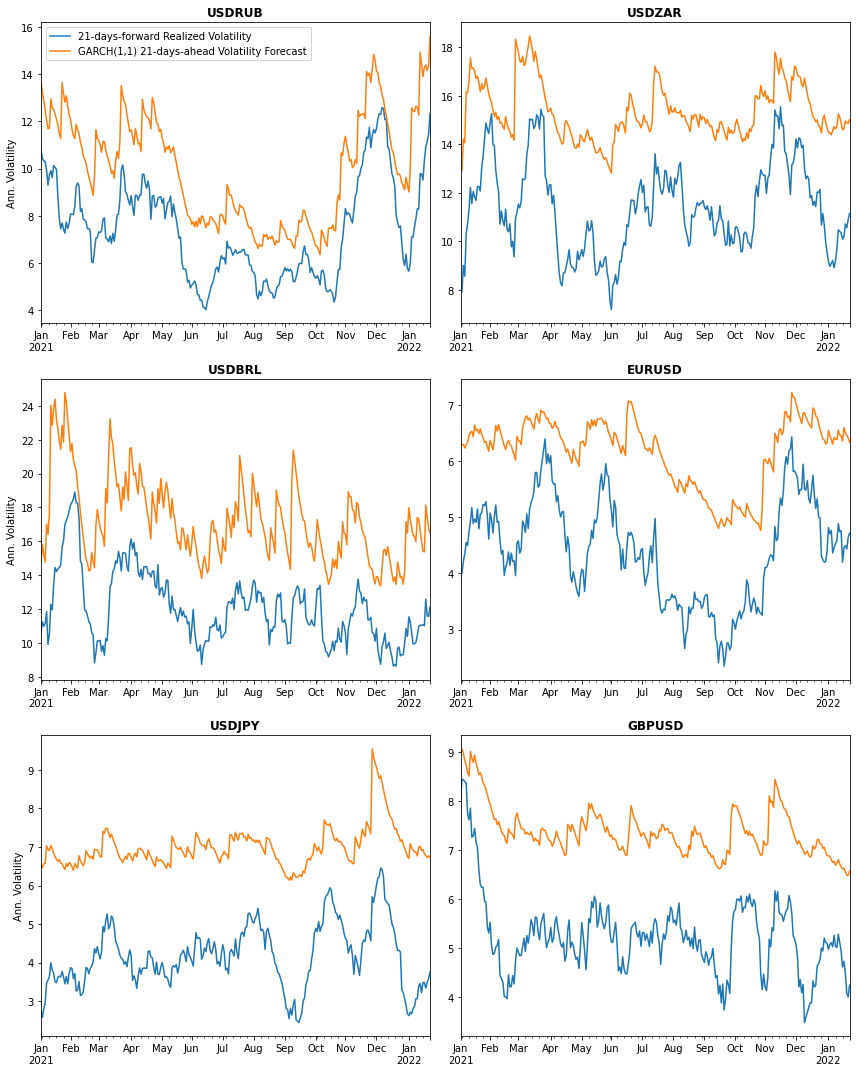

In [22]:
plot_grid_forecasted_vs_realized(df_dict=dfs, implied=False)

## Generate trading signals

We start by looking at 1 pair, e.g. USDRUB.

We can either hold to maturity (``days_holding_period`` $=21$) and get: 
$$ PnL = sign(direction) * (realized^{\ next \ 21 \ days} - implied^{\ now}) - 2 * spread $$

or we can close trade by going opposite direction after ``days_holding_period``$ = 0<x<21$ days and get:
$$ PnL = sign(direction) * (implied^{\ in \ x \ days} - implied^{\ now}) - 2 * spread $$


In [ ]:
threshold_up = 1.1
threshold_down = 0.9
days_holding_period = 5 # 21
pair = 'USDBRL'
df = dfs[pair].copy(deep=True)

In [ ]:
gen_trading_signals(df, thres_up=threshold_up,thres_down=threshold_down, days_holding_period = days_holding_period)
df.tail(10)

## How does the trades look?

In [ ]:
plot_trades(df=df,
            thres_up=threshold_up,
            thres_down=threshold_down, 
            #include_implied=True, 
            #include_forecasted=True,
            )

As can be seen from the graph, we are short vol the whole period due to the thresholds....

In [ ]:
calc_pnl(df,plot=True)